<a href="https://colab.research.google.com/github/abldvd/CI-Proyects/blob/main/MusicClassifier_Spectrogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pydub

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = 'drive/MyDrive/Colab Notebooks/datasets/music_files/test'
MAX_AUDIO_LEN = 60
BIN_SIZE = 2**11
!ls drive/MyDrive/'Colab Notebooks'/datasets/music_files/test

Classical  Rock  Synthwave


In [ ]:
import os
import math
import librosa
import numpy as np
import random as rd
from pydub import AudioSegment 
from pydub.utils import make_chunks
from scipy.io import wavfile
from tempfile import mktemp
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
def mp32wav(mp3_path, len=None):
  mp3_audio = AudioSegment.from_file(mp3_path, format="mp3")  # read mp3
  if len and len > mp3_audio.duration_seconds:
      raise Exception('Fixed lenght greater than file lenght')
  wname = mktemp('.wav')  # use temporary file
  if len:
    random_midpoint = np.random.randint(int(len*1000/2), int(mp3_audio.duration_seconds*1000 - len*1000/2))
    mp3_audio = mp3_audio[
      random_midpoint - len*1000/2:  
      random_midpoint + len*1000/2] # crop and save to wav
  mp3_audio.export(wname, format="wav")  
  rate, audio = wavfile.read(wname)  # read as wav file
  os.remove(wname) # dont want leaks here
  return audio, rate

In [ ]:
def getSpectrogram(mp3_path, bin_size, len): 
  audio, rate = mp32wav(mp3_path, len)  # get wave file  
  audio = np.mean(audio, axis=1)

  spectrum = librosa.stft(audio, n_fft=bin_size, hop_length=int(rate))
  return spectrum[:, :-1].reshape(spectrum[:, :-1].shape + (1,))

In [ ]:
def loadSpectrumData(path, seed=1234, file_limit=200):
  # Loads data from a main folder, having the option to split into validation or training 
  first_file_shape = getSpectrogram(f'{path}/{os.listdir(path)[0]}/{os.listdir(f"{path}/{os.listdir(path)[0]}")[0]}', BIN_SIZE, MAX_AUDIO_LEN).shape
  num_files = int(sum([len(os.listdir(f'{path}/{class_folder}')[:file_limit]) for class_folder in os.listdir(path)]))
  num_classes = len(os.listdir(path))
                             # Inits   
  X = np.zeros((num_files,) + first_file_shape, dtype = 'complex_')  # Lets assume every spectrum will have the same shape
  y = np.zeros(num_files, dtype=str)

  rd.seed(seed)
  last_i = 0
  for class_folder in os.listdir(path): # Iterating over the classes
    file_list = os.listdir(f'{path}/{class_folder}')
    rd.shuffle(file_list)
    if file_limit:       # Appliying memory limits and randomizing
      file_list = file_list[:file_limit]
      rd.shuffle(file_list)

    for i, file_name in enumerate(file_list): 
      try:                 
                              # Iterating and loading spectrum
        X[last_i+i,] = getSpectrogram(f'{path}/{class_folder}/{file_name}', BIN_SIZE, MAX_AUDIO_LEN)

      except ValueError as v: # Our assumption was wrong, some files had a rounding error and had one less half a second
        missed_file = getSpectrogram(f'{path}/{class_folder}/{file_name}', BIN_SIZE, MAX_AUDIO_LEN) 
        X[last_i+i,] = np.c_[missed_file, np.ones(np.shape(missed_file)[0], dtype = 'complex_')] # Lets add something so we dont lose the sample
      y[last_i+i] = class_folder
    last_i += i+1
        
  lb = LabelEncoder() # Transforming y to categorical
  y = keras.utils.to_categorical(lb.fit_transform(y), num_classes=num_classes)
  return X,  y

In [ ]:
# DATA --------------------------------------------------------------
num_classes = len(os.listdir(PATH))
input_shape = getSpectrogram(f'{PATH}/{os.listdir(PATH)[0]}/{os.listdir(f"{PATH}/{os.listdir(PATH)[0]}")[0]}', BIN_SIZE, MAX_AUDIO_LEN).shape
X, y = loadSpectrumData(PATH)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
# MODEL ------------------------------------------------------------
model = keras.Sequential() 
model.add(layers.BatchNormalization(input_shape=input_shape))
model.add(layers.Conv2D(50, kernel_size=(4, 2), strides=(4, 1), activation='relu'))
model.add(layers.Dropout(0.125))
model.add(layers.AveragePooling2D(pool_size=(2, 3)))
model.add(layers.Conv2D(100, kernel_size=(4, 2), strides=(4, 1), activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.AveragePooling2D(pool_size=(2, 3)))
model.add(layers.Conv2D(200, kernel_size=(4, 2), strides=(4, 1), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.AveragePooling2D(pool_size=(2, 3)))


model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [ ]:
# TRAINING --------------------------------------------------

epochs = 300

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15, restore_best_weights=True)

h = model.fit(
        x=X_train, y=y_train, 
        batch_size=44,
        epochs=epochs,
        callbacks = [es], 
        validation_data=(X_test, y_test)
)

Epoch 1/300
10/10 [==============================] - 2s 141ms/step - loss: 0.9949 - accuracy: 0.3806 - val_loss: 0.9183 - val_accuracy: 0.4091
Epoch 2/300
10/10 [==============================] - 1s 94ms/step - loss: 0.7752 - accuracy: 0.7189 - val_loss: 0.6616 - val_accuracy: 0.7677
Epoch 3/300
10/10 [==============================] - 1s 96ms/step - loss: 0.5657 - accuracy: 0.7886 - val_loss: 0.5898 - val_accuracy: 0.7828
Epoch 4/300
10/10 [==============================] - 1s 95ms/step - loss: 0.4030 - accuracy: 0.8408 - val_loss: 0.6479 - val_accuracy: 0.7576
Epoch 5/300
10/10 [==============================] - 1s 96ms/step - loss: 0.5186 - accuracy: 0.8159 - val_loss: 0.7652 - val_accuracy: 0.6667
Epoch 6/300
10/10 [==============================] - 1s 96ms/step - loss: 0.4309 - accuracy: 0.8184 - val_loss: 0.6312 - val_accuracy: 0.7525
Epoch 7/300
10/10 [==============================] - 1s 97ms/step - loss: 0.4245 - accuracy: 0.8060 - val_loss: 0.4839 - val_accuracy: 0.8030
Epoch

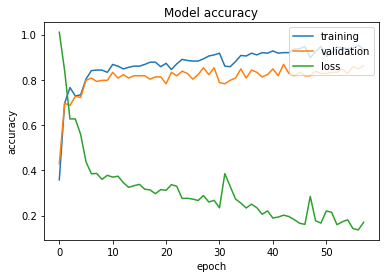

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss'], loc='upper right')
plt.show()